In [ ]:
%pip install tensorflow keras numpy pandas matplotlib scikit-learn keras-tuner building_footprint_segmentation

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.8 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:

import zipfile

zip_ref = zipfile.ZipFile("/content/drive/fill_the_file_name.zip", 'r')
zip_ref.extractall("/content/dataset")
zip_ref.close()

GPUs Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Training model with combined training data:
Classes in '/content/drive/MyDrive/RA Satellite Imagery Work/Abduls RA Work Folder/SAT_Images/Phase 2': ['Hospital', 'High', 'Commercial', 'Schools', 'Single', 'Industrial', 'Multi']
Classes in '/content/drive/MyDrive/ML/Model/train': ['Commercial', 'Hospital', 'High', 'Industrial', 'Schools', 'Single', 'Multi']
Combined Classes from Training Directories: ['Commercial', 'High', 'Hospital', 'Industrial', 'Multi', 'Schools', 'Single']
Training with classes: ['Commercial', 'High', 'Hospital', 'Industrial', 'Multi', 'Schools', 'Single']
Training images: 2096
Validation images: 60
Test images: 60
74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 341s 2s/step - accuracy: 0.3164 - loss: 2.9532 - val_accuracy: 0.6833 - val_loss: 1.9798 - learning_rate: 5.0000e-05
Epoch 2/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - accuracy: 0.

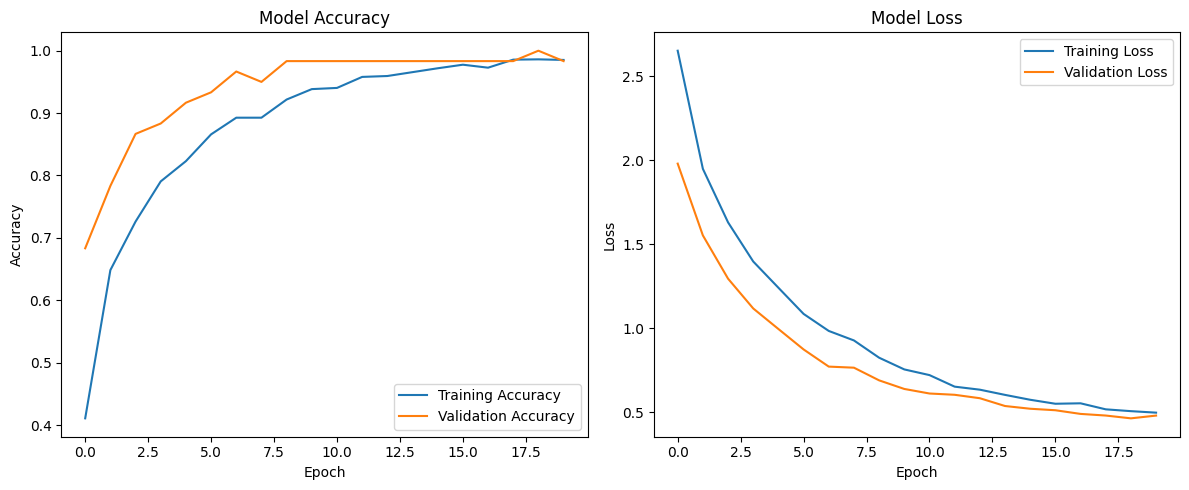

2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step - accuracy: 0.9778 - loss: 0.5442
Test Accuracy: 96.6667%
2/2 ━━━━━━━━━━━━━━━━━━━━ 35s 17s/step
Confusion Matrix:
 [[10  0  0  0  0  0]
 [ 0 10  0  0  0  0]
 [ 0  0 10  0  0  0]
 [ 0  0  0 10  0  0]
 [ 0  0  0  0 10  0]
 [ 0  0  0  0  2  8]]
Classification Report:
               precision    recall  f1-score   support

  Commercial       1.00      1.00      1.00        10
        High       1.00      1.00      1.00        10
    Hospital       1.00      1.00      1.00        10
  Industrial       1.00      1.00      1.00        10
       Multi       0.83      1.00      0.91        10
     Schools       0.00      0.00      0.00         0
      Single       1.00      0.80      0.89        10

    accuracy                           0.97        60
   macro avg       0.83      0.83      0.83        60
weighted avg       0.97      0.97      0.97        60


Test Accuracy: 96.6667%


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report
from PIL import Image
import matplotlib.pyplot as plt  # Import for plotting training history

# Enable mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

# Verify GPU availability
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPUs Available:", gpus)
else:
    print("No GPU found. Please ensure that TensorFlow is configured properly.")

# Set the image size and batch size
img_size = (224, 224)
batch_size = 32

# Set the base directories for the data
existing_train_dir = '/content/drive/MyDrive/RA Satellite Imagery Work/Abduls RA Work Folder/SAT_Images/Phase 2'
new_data_dir = '/content/drive/MyDrive/ML/Model/train'
existing_val_dir = '/content/drive/MyDrive/ML/Model/val'
existing_test_dir = '/content/drive/MyDrive/ML/Model/test'

# Function to get class names from training directories
def get_class_names(directories):
    class_names = set()
    for directory in directories:
        classes_in_dir = [item for item in os.listdir(directory) if os.path.isdir(os.path.join(directory, item))]
        print(f"Classes in '{directory}': {classes_in_dir}")
        class_names.update(classes_in_dir)
    class_names = sorted(list(class_names))
    print("Combined Classes from Training Directories:", class_names)
    return class_names

# Function to collect data paths from multiple directories
def collect_data_paths(data_directories, class_names):
    image_paths = []
    labels = []
    class_indices = {class_name: idx for idx, class_name in enumerate(class_names)}
    for data_directory in data_directories:
        for class_name in class_names:
            folder_path = os.path.join(data_directory, class_name)
            if os.path.isdir(folder_path):
                for img_file in os.listdir(folder_path):
                    img_path = os.path.join(folder_path, img_file)
                    if img_file.lower().endswith(('.tif', '.tiff', '.jpg', '.jpeg', '.png', '.bmp', '.gif')):
                        image_paths.append(img_path)
                        labels.append(class_indices[class_name])
    return image_paths, labels

# Function to load and preprocess image with PIL
def load_image_with_pil(filename):
    filename = filename.decode('utf-8')
    image = Image.open(filename).convert('RGB')
    image = image.resize(img_size)
    image = np.array(image) / 255.0  # Normalize to [0,1]
    return image.astype(np.float32)

# Function to parse and preprocess images using PIL
def parse_function(filename, label):
    image = tf.numpy_function(load_image_with_pil, [filename], tf.float32)
    image.set_shape([img_size[0], img_size[1], 3])
    return image, label

# Data augmentation using Keras preprocessing layers
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

# Function to create datasets
def create_dataset(image_paths, labels, training=True):
    labels = np.array(labels)
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(parse_function, num_parallel_calls=tf.data.AUTOTUNE)
    if training:
        dataset = dataset.shuffle(buffer_size=1024)
        dataset = dataset.batch(batch_size)
        dataset = dataset.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)
    else:
        dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# Function to build the model with regularization and adjusted dropout
def build_model(num_classes):
    with tf.device('/GPU:0'):
        base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))
        for layer in base_model.layers[:500]:
            layer.trainable = False
        for layer in base_model.layers[500:]:
            layer.trainable = True

        # Input layer
        inputs = Input(shape=(img_size[0], img_size[1], 3))
        x = inputs
        x = base_model(x, training=True)
        x = GlobalAveragePooling2D()(x)
        x = Dense(768, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)  # Added L2 regularization
        x = Dropout(0.5)(x)  # Increased dropout rate to 0.5
        outputs = Dense(num_classes, activation='softmax', dtype='float32')(x)

        model = Model(inputs, outputs)

        # Compile the model
        optimizer = Adam(learning_rate=5e-5)  # Adjusted learning rate
        optimizer = mixed_precision.LossScaleOptimizer(optimizer)
        model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

# Function to plot training history
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

# Function to train and evaluate the model
def train_and_evaluate(train_dirs, val_dir, test_dir, img_size=(224, 224), batch_size=32, epochs=20):
    class_names = get_class_names(train_dirs)

    train_image_paths, train_labels = collect_data_paths(train_dirs, class_names)
    val_image_paths, val_labels = collect_data_paths([val_dir], class_names)
    test_image_paths, test_labels = collect_data_paths([test_dir], class_names)

    num_classes = len(class_names)
    print(f"Training with classes: {class_names}")

    print(f"Training images: {len(train_image_paths)}")
    print(f"Validation images: {len(val_image_paths)}")
    print(f"Test images: {len(test_image_paths)}")

    train_dataset = create_dataset(train_image_paths, train_labels, training=True)
    val_dataset = create_dataset(val_image_paths, val_labels, training=False)
    test_dataset = create_dataset(test_image_paths, test_labels, training=False)

    model = build_model(num_classes)

    # Early stopping and learning rate scheduler
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)  # Reduced patience to 3
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)  # Learning rate scheduler

    history = model.fit(
        train_dataset,
        epochs=epochs,
        validation_data=val_dataset,
        callbacks=[early_stopping, reduce_lr]
    )

    model.save('/content/drive/MyDrive/Madhu RA Work Folder/Densenet201_combined.h5')

    plot_training_history(history)

    test_loss, test_accuracy = model.evaluate(test_dataset)
    print(f"Test Accuracy: {test_accuracy:.4%}")

    y_true = np.concatenate([y.numpy() for x, y in test_dataset], axis=0)
    y_pred_probs = model.predict(test_dataset)
    y_pred = np.argmax(y_pred_probs, axis=1)

    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:\n", cm)

    labels = range(num_classes)
    cr = classification_report(y_true, y_pred, labels=labels, target_names=class_names, zero_division=0)
    print("Classification Report:\n", cr)

    return test_accuracy

if __name__ == "__main__":
    train_dirs = [existing_train_dir, new_data_dir]

    print("\nTraining model with combined training data:")
    test_accuracy = train_and_evaluate(train_dirs, existing_val_dir, existing_test_dir)

    print(f"\nTest Accuracy: {test_accuracy:.4%}")


GPUs Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Training model with combined training data:
Classes in '/content/drive/MyDrive/RA Satellite Imagery Work/Abduls RA Work Folder/SAT_Images/Phase 2': ['Hospital', 'High', 'Commercial', 'Schools', 'Single', 'Industrial', 'Multi']
Classes in '/content/drive/MyDrive/ML/Model/train': ['Commercial', 'Hospital', 'High', 'Industrial', 'Schools', 'Single', 'Multi']
Combined Classes from Training Directories: ['Commercial', 'High', 'Hospital', 'Industrial', 'Multi', 'Schools', 'Single']
Training with classes: ['Commercial', 'High', 'Hospital', 'Industrial', 'Multi', 'Schools', 'Single']
Training images: 2096
Validation images: 60
Test images: 60
74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 306s 2s/step - accuracy: 0.3176 - loss: 2.9792 - val_accuracy: 0.7500 - val_loss: 1.9365 - learning_rate: 5.0000e-05
Epoch 2/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - accuracy: 0.

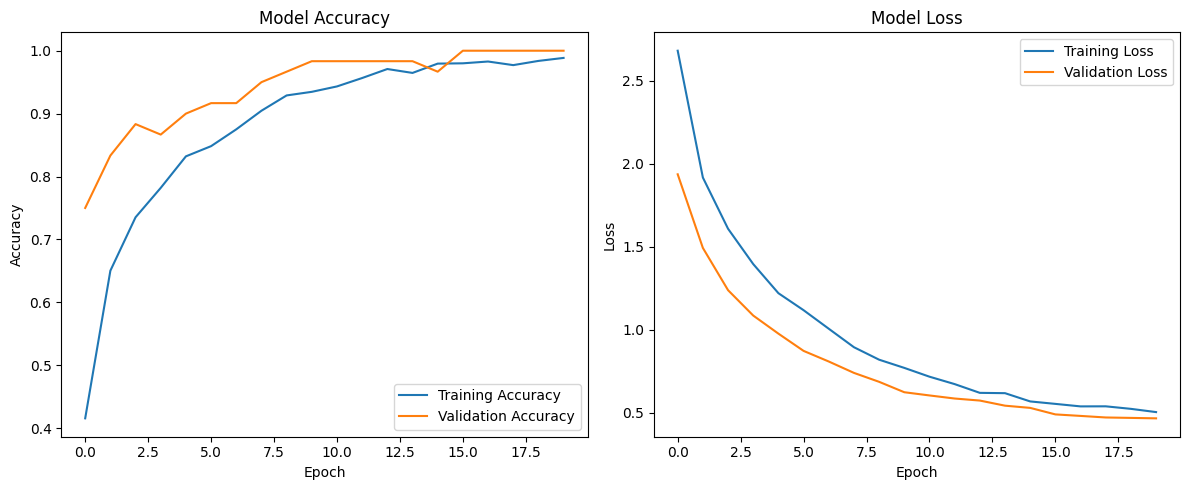

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.9778 - loss: 0.5360
Test Accuracy: 96.6667%
2/2 ━━━━━━━━━━━━━━━━━━━━ 33s 16s/step
Confusion Matrix:
 [[10  0  0  0  0  0]
 [ 0 10  0  0  0  0]
 [ 0  0 10  0  0  0]
 [ 0  0  0 10  0  0]
 [ 0  0  0  0 10  0]
 [ 0  0  0  0  2  8]]
Classification Report:
               precision    recall  f1-score   support

  Commercial       1.00      1.00      1.00        10
        High       1.00      1.00      1.00        10
    Hospital       1.00      1.00      1.00        10
  Industrial       1.00      1.00      1.00        10
       Multi       0.83      1.00      0.91        10
     Schools       0.00      0.00      0.00         0
      Single       1.00      0.80      0.89        10

    accuracy                           0.97        60
   macro avg       0.83      0.83      0.83        60
weighted avg       0.97      0.97      0.97        60


Test Accuracy: 96.6667%


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report
from PIL import Image
import matplotlib.pyplot as plt  # Import for plotting training history

# Enable mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

# Verify GPU availability
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPUs Available:", gpus)
else:
    print("No GPU found. Please ensure that TensorFlow is configured properly.")

# Set the image size and batch size
img_size = (224, 224)
batch_size = 32

# Set the base directories for the data
existing_train_dir = '/content/drive/MyDrive/RA Satellite Imagery Work/Abduls RA Work Folder/SAT_Images/Phase 2'
new_data_dir = '/content/drive/MyDrive/ML/Model/train'
existing_val_dir = '/content/drive/MyDrive/ML/Model/val'
existing_test_dir = '/content/drive/MyDrive/ML/Model/test'

# Function to get class names from training directories
def get_class_names(directories):
    class_names = set()
    for directory in directories:
        classes_in_dir = [item for item in os.listdir(directory) if os.path.isdir(os.path.join(directory, item))]
        print(f"Classes in '{directory}': {classes_in_dir}")
        class_names.update(classes_in_dir)
    class_names = sorted(list(class_names))
    print("Combined Classes from Training Directories:", class_names)
    return class_names

# Function to collect data paths from multiple directories
def collect_data_paths(data_directories, class_names):
    image_paths = []
    labels = []
    class_indices = {class_name: idx for idx, class_name in enumerate(class_names)}
    for data_directory in data_directories:
        for class_name in class_names:
            folder_path = os.path.join(data_directory, class_name)
            if os.path.isdir(folder_path):
                for img_file in os.listdir(folder_path):
                    img_path = os.path.join(folder_path, img_file)
                    if img_file.lower().endswith(('.tif', '.tiff', '.jpg', '.jpeg', '.png', '.bmp', '.gif')):
                        image_paths.append(img_path)
                        labels.append(class_indices[class_name])
    return image_paths, labels

# Function to load and preprocess image with PIL
def load_image_with_pil(filename):
    filename = filename.decode('utf-8')
    image = Image.open(filename).convert('RGB')
    image = image.resize(img_size)
    image = np.array(image) / 255.0  # Normalize to [0,1]
    return image.astype(np.float32)

# Function to parse and preprocess images using PIL
def parse_function(filename, label):
    image = tf.numpy_function(load_image_with_pil, [filename], tf.float32)
    image.set_shape([img_size[0], img_size[1], 3])
    return image, label

# Data augmentation using Keras preprocessing layers
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

# Function to create datasets
def create_dataset(image_paths, labels, training=True):
    labels = np.array(labels)
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(parse_function, num_parallel_calls=tf.data.AUTOTUNE)
    if training:
        dataset = dataset.shuffle(buffer_size=1024)
        dataset = dataset.batch(batch_size)
        dataset = dataset.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)
    else:
        dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# Function to build the model with regularization and adjusted dropout
def build_model(num_classes):
    with tf.device('/GPU:0'):
        base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))
        for layer in base_model.layers[:500]:
            layer.trainable = False
        for layer in base_model.layers[500:]:
            layer.trainable = True

        # Input layer
        inputs = Input(shape=(img_size[0], img_size[1], 3))
        x = inputs
        x = base_model(x, training=True)
        x = GlobalAveragePooling2D()(x)
        x = Dense(768, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)  # Added L2 regularization
        x = Dropout(0.5)(x)  # Increased dropout rate to 0.5
        outputs = Dense(num_classes, activation='softmax', dtype='float32')(x)

        model = Model(inputs, outputs)

        # Compile the model
        optimizer = Adam(learning_rate=5e-5)  # Adjusted learning rate
        optimizer = mixed_precision.LossScaleOptimizer(optimizer)
        model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

# Function to plot training history
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

# Function to train and evaluate the model
def train_and_evaluate(train_dirs, val_dir, test_dir, img_size=(224, 224), batch_size=32, epochs=20):
    class_names = get_class_names(train_dirs)

    train_image_paths, train_labels = collect_data_paths(train_dirs, class_names)
    val_image_paths, val_labels = collect_data_paths([val_dir], class_names)
    test_image_paths, test_labels = collect_data_paths([test_dir], class_names)

    num_classes = len(class_names)
    print(f"Training with classes: {class_names}")

    print(f"Training images: {len(train_image_paths)}")
    print(f"Validation images: {len(val_image_paths)}")
    print(f"Test images: {len(test_image_paths)}")

    train_dataset = create_dataset(train_image_paths, train_labels, training=True)
    val_dataset = create_dataset(val_image_paths, val_labels, training=False)
    test_dataset = create_dataset(test_image_paths, test_labels, training=False)

    model = build_model(num_classes)

    # Early stopping and learning rate scheduler
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)  # Reduced patience to 3
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)  # Learning rate scheduler

    history = model.fit(
        train_dataset,
        epochs=epochs,
        validation_data=val_dataset,
        callbacks=[early_stopping, reduce_lr]
    )

    model.save('/content/drive/MyDrive/Madhu RA Work Folder/Densenet201_combined_1.h5')

    plot_training_history(history)

    test_loss, test_accuracy = model.evaluate(test_dataset)
    print(f"Test Accuracy: {test_accuracy:.4%}")

    y_true = np.concatenate([y.numpy() for x, y in test_dataset], axis=0)
    y_pred_probs = model.predict(test_dataset)
    y_pred = np.argmax(y_pred_probs, axis=1)

    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:\n", cm)

    labels = range(num_classes)
    cr = classification_report(y_true, y_pred, labels=labels, target_names=class_names, zero_division=0)
    print("Classification Report:\n", cr)

    return test_accuracy

if __name__ == "__main__":
    train_dirs = [existing_train_dir, new_data_dir]

    print("\nTraining model with combined training data:")
    test_accuracy = train_and_evaluate(train_dirs, existing_val_dir, existing_test_dir)

    print(f"\nTest Accuracy: {test_accuracy:.4%}")


GPUs Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Training model with combined training data:
Classes in '/content/drive/MyDrive/RA Satellite Imagery Work/Abduls RA Work Folder/SAT_Images/Phase 2': ['Hospital', 'High', 'Commercial', 'Schools', 'Single', 'Industrial', 'Multi']
Classes in '/content/drive/MyDrive/ML/Model/train': ['Commercial', 'Hospital', 'High', 'Industrial', 'Schools', 'Single', 'Multi']
Combined Classes from Training Directories: ['Commercial', 'High', 'Hospital', 'Industrial', 'Multi', 'Schools', 'Single']
Training with classes: ['Commercial', 'High', 'Hospital', 'Industrial', 'Multi', 'Schools', 'Single']
Total images collected: 2096
Training images: 1886
Temp images (for validation and testing): 210
Validation images: 105
Test images: 105
74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 287s 2s/step - accuracy: 0.2599 - loss: 2.9919 - val_accuracy: 0.6190 - val_loss: 2.0797 - learning_rate: 5

Model saved at /content/drive/MyDrive/Madhu RA Work Folder/Densenet201_combined_2.h5.


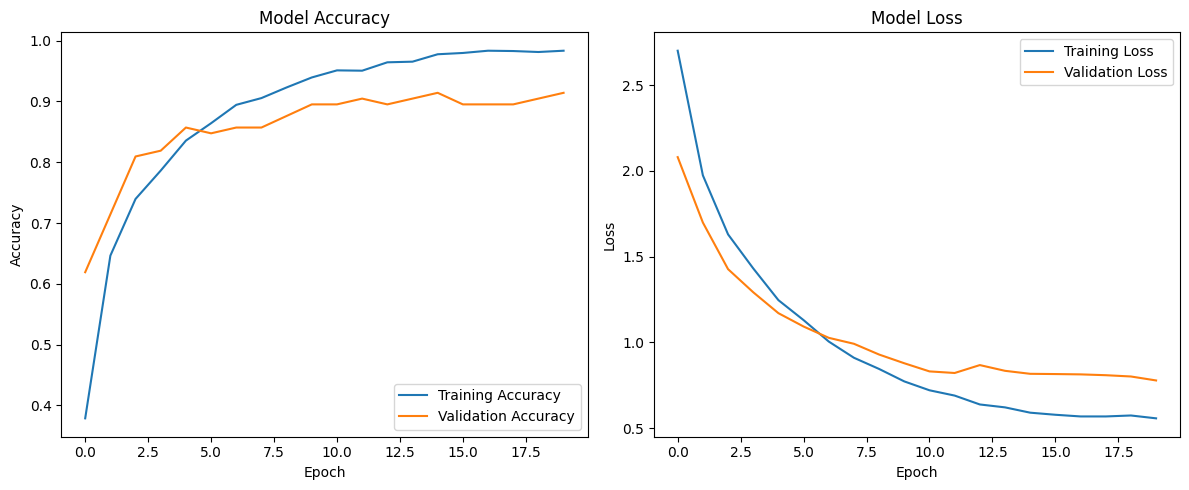

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 484ms/step - accuracy: 0.8911 - loss: 0.7614
Test Accuracy: 87.6190%
4/4 ━━━━━━━━━━━━━━━━━━━━ 33s 6s/step
Confusion Matrix:
 [[11  0  0  0  3  0  0]
 [ 1 18  0  0  0  0  0]
 [ 0  0 14  0  0  0  0]
 [ 2  0  0 13  0  0  0]
 [ 1  1  0  0 12  0  1]
 [ 2  0  0  1  0 11  0]
 [ 0  0  0  0  1  0 13]]
Classification Report:
               precision    recall  f1-score   support

  Commercial       0.65      0.79      0.71        14
        High       0.95      0.95      0.95        19
    Hospital       1.00      1.00      1.00        14
  Industrial       0.93      0.87      0.90        15
       Multi       0.75      0.80      0.77        15
     Schools       1.00      0.79      0.88        14
      Single       0.93      0.93      0.93        14

    accuracy                           0.88       105
   macro avg       0.89      0.87      0.88       105
weighted avg       0.89      0.88      0.88       105


Final Test Accuracy: 87.6190%


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split  # Added for data splitting
from PIL import Image
import matplotlib.pyplot as plt  # Import for plotting training history
import logging  # Added for logging

# Enable mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

# Configure logging
logging.basicConfig(
    filename='model_training.log',
    level=logging.INFO,
    format='%(asctime)s:%(levelname)s:%(message)s'
)

# Verify GPU availability
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPUs Available:", gpus)
    logging.info(f"GPUs Available: {gpus}")
else:
    print("No GPU found. Please ensure that TensorFlow is configured properly.")
    logging.warning("No GPU found. Using CPU for training.")

# Set the image size and batch size
img_size = (224, 224)
batch_size = 32

# Set the base directories for the data
existing_train_dir = '/content/drive/MyDrive/RA Satellite Imagery Work/Abduls RA Work Folder/SAT_Images/Phase 2'
new_data_dir = '/content/drive/MyDrive/ML/Model/train'

# Function to get class names from training directories
def get_class_names(directories):
    class_names = set()
    for directory in directories:
        if not os.path.isdir(directory):
            logging.warning(f"Directory '{directory}' does not exist. Skipping.")
            continue
        classes_in_dir = [item for item in os.listdir(directory) if os.path.isdir(os.path.join(directory, item))]
        print(f"Classes in '{directory}': {classes_in_dir}")
        logging.info(f"Classes in '{directory}': {classes_in_dir}")
        class_names.update(classes_in_dir)
    class_names = sorted(list(class_names))
    print("Combined Classes from Training Directories:", class_names)
    logging.info(f"Combined Classes from Training Directories: {class_names}")
    return class_names

# Function to collect data paths from multiple directories
def collect_data_paths(data_directories, class_names):
    image_paths = []
    labels = []
    class_indices = {class_name: idx for idx, class_name in enumerate(class_names)}
    for data_directory in data_directories:
        if not os.path.isdir(data_directory):
            logging.warning(f"Data directory '{data_directory}' does not exist. Skipping.")
            continue
        for class_name in class_names:
            folder_path = os.path.join(data_directory, class_name)
            if not os.path.isdir(folder_path):
                logging.warning(f"Class directory '{folder_path}' does not exist. Skipping.")
                continue
            for img_file in os.listdir(folder_path):
                img_path = os.path.join(folder_path, img_file)
                if img_file.lower().endswith(('.tif', '.tiff', '.jpg', '.jpeg', '.png', '.bmp', '.gif')):
                    image_paths.append(img_path)
                    labels.append(class_indices[class_name])
    return image_paths, labels

# Function to load and preprocess image with PIL
def load_image_with_pil(filename):
    filename = filename.decode('utf-8')
    try:
        image = Image.open(filename).convert('RGB')
        image = image.resize(img_size)
        image = np.array(image) / 255.0  # Normalize to [0,1]
        return image.astype(np.float32)
    except Exception as e:
        logging.error(f"Error loading image {filename}: {e}")
        return np.zeros((*img_size, 3), dtype=np.float32)  # Return a black image in case of error

# Function to parse and preprocess images using PIL
def parse_function(filename, label):
    image = tf.numpy_function(load_image_with_pil, [filename], tf.float32)
    image.set_shape([img_size[0], img_size[1], 3])
    return image, label

# Data augmentation using Keras preprocessing layers
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

# Function to create datasets
def create_dataset(image_paths, labels, training=True):
    labels = np.array(labels)
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(parse_function, num_parallel_calls=tf.data.AUTOTUNE)
    if training:
        dataset = dataset.shuffle(buffer_size=1024)
        dataset = dataset.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# Function to build the model with regularization and adjusted dropout
def build_model(num_classes):
    with tf.device('/GPU:0'):
        base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))
        for layer in base_model.layers[:500]:
            layer.trainable = False
        for layer in base_model.layers[500:]:
            layer.trainable = True

        # Input layer
        inputs = Input(shape=(img_size[0], img_size[1], 3))
        x = inputs
        x = base_model(x, training=True)
        x = GlobalAveragePooling2D()(x)
        x = Dense(768, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)  # Added L2 regularization
        x = Dropout(0.5)(x)  # Increased dropout rate to 0.5
        outputs = Dense(num_classes, activation='softmax', dtype='float32')(x)

        model = Model(inputs, outputs)

        # Compile the model
        optimizer = Adam(learning_rate=5e-5)  # Adjusted learning rate
        optimizer = mixed_precision.LossScaleOptimizer(optimizer)
        model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

# Function to plot training history
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

# Function to train and evaluate the model
def train_and_evaluate(train_dirs, img_size=(224, 224), batch_size=32, epochs=20):
    class_names = get_class_names(train_dirs)

    # Collect all image paths and labels from training directories
    all_image_paths, all_labels = collect_data_paths(train_dirs, class_names)

    num_classes = len(class_names)
    print(f"Training with classes: {class_names}")
    logging.info(f"Training with classes: {class_names}")

    print(f"Total images collected: {len(all_image_paths)}")
    logging.info(f"Total images collected: {len(all_image_paths)}")

    # Split the data into train (80%), temp (20%)
    train_paths, temp_paths, train_labels, temp_labels = train_test_split(
        all_image_paths, all_labels, test_size=0.1, stratify=all_labels, random_state=42
    )
    print(f"Training images: {len(train_paths)}")
    print(f"Temp images (for validation and testing): {len(temp_paths)}")
    logging.info(f"Training images: {len(train_paths)}")
    logging.info(f"Temp images (for validation and testing): {len(temp_paths)}")

    # Further split temp into validation (10%) and test (10%)
    val_paths, test_paths, val_labels, test_labels = train_test_split(
        temp_paths, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42
    )
    print(f"Validation images: {len(val_paths)}")
    print(f"Test images: {len(test_paths)}")
    logging.info(f"Validation images: {len(val_paths)}")
    logging.info(f"Test images: {len(test_paths)}")

    # Create datasets
    train_dataset = create_dataset(train_paths, train_labels, training=True)
    val_dataset = create_dataset(val_paths, val_labels, training=False)
    test_dataset = create_dataset(test_paths, test_labels, training=False)

    # Build the model
    model = build_model(num_classes)
    logging.info("Model built and compiled successfully.")

    # Early stopping and learning rate scheduler
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)  # Reduced patience to 3
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)  # Learning rate scheduler

    # Train the model
    history = model.fit(
        train_dataset,
        epochs=epochs,
        validation_data=val_dataset,
        callbacks=[early_stopping, reduce_lr]
    )
    logging.info("Model training completed.")

    # Save the model
    model_save_path = '/content/drive/MyDrive/Madhu RA Work Folder/Densenet201_combined_2.h5'
    model.save(model_save_path)
    print(f"Model saved at {model_save_path}.")
    logging.info(f"Model saved at {model_save_path}.")

    # Plot training history
    plot_training_history(history)
    logging.info("Training history plotted.")

    # Evaluate on test dataset
    test_loss, test_accuracy = model.evaluate(test_dataset)
    print(f"Test Accuracy: {test_accuracy:.4%}")
    logging.info(f"Test Accuracy: {test_accuracy:.4%}")

    # Generate predictions and evaluate
    y_true = np.concatenate([y.numpy() for x, y in test_dataset], axis=0)
    y_pred_probs = model.predict(test_dataset)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:\n", cm)
    logging.info(f"Confusion Matrix:\n{cm}")

    # Classification Report
    cr = classification_report(y_true, y_pred, labels=range(num_classes), target_names=class_names, zero_division=0)
    print("Classification Report:\n", cr)
    logging.info(f"Classification Report:\n{cr}")

    return test_accuracy

if __name__ == "__main__":
    train_dirs = [existing_train_dir, new_data_dir]

    print("\nTraining model with combined training data:")
    logging.info("Starting model training with combined training data.")
    test_accuracy = train_and_evaluate(train_dirs, img_size=img_size, batch_size=batch_size, epochs=20)

    print(f"\nFinal Test Accuracy: {test_accuracy:.4%}")
    logging.info(f"Final Test Accuracy: {test_accuracy:.4%}")


In [2]:
import numpy as np

# Define your confusion matrix
cm = np.array([
 [14,  0,  0,  2,  4,  0,  0],
 [ 0, 28,  0,  1,  1,  0,  0],
 [ 0, 0, 18,  0,  0,  2,  0],
 [ 1,  0,  0, 19,  0,  1,  0],
 [ 4,  0,  1,  0, 13,  1,  3],
 [ 0,  0,  3,  0,  1, 16,  0],
 [ 0,  0,  0,  0, 1,  0, 20]
])

# Calculate class-wise accuracy in percentage
class_accuracies = []
for i in range(len(cm)):
    class_accuracy = (cm[i][i] / sum(cm[i])) * 100
    class_accuracies.append(class_accuracy)

# Print the results
class_names = ["Commercial", "High", "Hospital", "Industrial", "Multi", "Schools", "Single"]
for i, class_name in enumerate(class_names):
    print(f"Accuracy for {class_name}: {class_accuracies[i]:.2f}%")


Accuracy for Commercial: 70.00%
Accuracy for High: 93.33%
Accuracy for Hospital: 90.00%
Accuracy for Industrial: 90.48%
Accuracy for Multi: 59.09%
Accuracy for Schools: 80.00%
Accuracy for Single: 95.24%


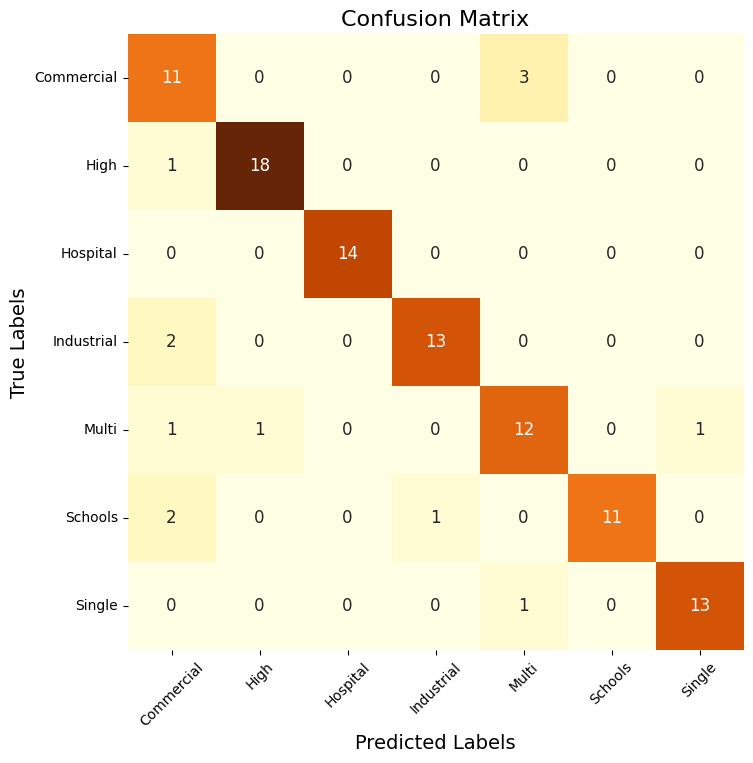

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Define your confusion matrix
cm = np.array([
    [11, 0, 0, 0, 3, 0, 0],
    [1, 18, 0, 0, 0, 0, 0],
    [0, 0, 14, 0, 0, 0, 0],
    [2, 0, 0, 13, 0, 0, 0],
    [1, 1, 0, 0, 12, 0, 1],
    [2, 0, 0, 1, 0, 11, 0],
    [0, 0, 0, 0, 1, 0, 13]
])

# Define class names
class_names = ["Commercial", "High", "Hospital", "Industrial", "Multi", "Schools", "Single"]

# Set up the figure
plt.figure(figsize=(10, 8))

# Create a custom colormap that mimics "yellow-brick" style
cmap = sns.color_palette("YlOrBr", as_cmap=True)

# Plot the heatmap
sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, cbar=False,
            xticklabels=class_names, yticklabels=class_names,
            annot_kws={"size": 12}, square=True)

# Add axis labels and title
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)
plt.xticks(rotation=45)
plt.yticks(rotation=0)

# Display the plot
plt.show()


GPUs Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Training model with combined training data:
Classes in '/content/drive/MyDrive/RA Satellite Imagery Work/Abduls RA Work Folder/SAT_Images/Phase 2': ['Hospital', 'High', 'Commercial', 'Schools', 'Single', 'Industrial', 'Multi']
Classes in '/content/drive/MyDrive/ML/Model/train': ['Commercial', 'Hospital', 'High', 'Industrial', 'Schools', 'Single', 'Multi']
Combined Classes from Training Directories: ['Commercial', 'High', 'Hospital', 'Industrial', 'Multi', 'Schools', 'Single']
Training with classes: ['Commercial', 'High', 'Hospital', 'Industrial', 'Multi', 'Schools', 'Single']
Total images collected: 2096
Training images: 1676
Temp images (for validation and testing): 420
Validation images: 210
Test images: 210
Epoch 1/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 153s 1s/step - accuracy: 0.2615 - loss: 3.0087 - val_accuracy: 0.6000 - val_loss: 2.2427 - learning_rate: 5.0000e-05
Epoch 2/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 10s

Model saved at /content/drive/MyDrive/Madhu RA Work Folder/Densenet201_combined_3.h5.


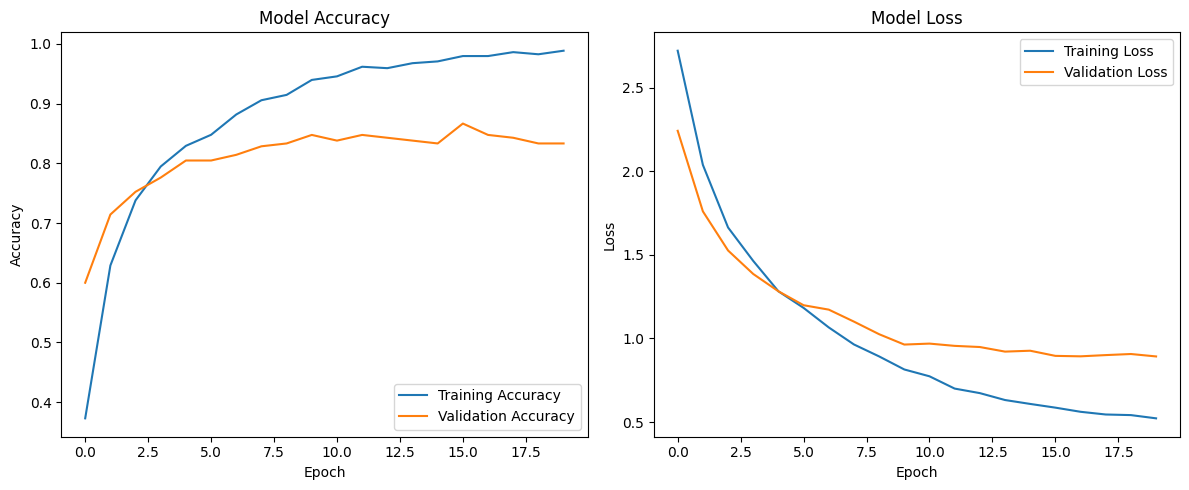

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step - accuracy: 0.8654 - loss: 1.0699
Test Accuracy: 86.1905%


7/7 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step


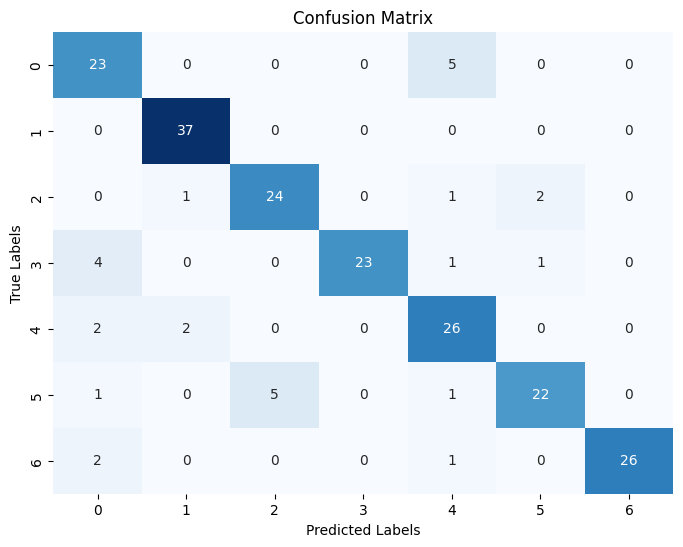

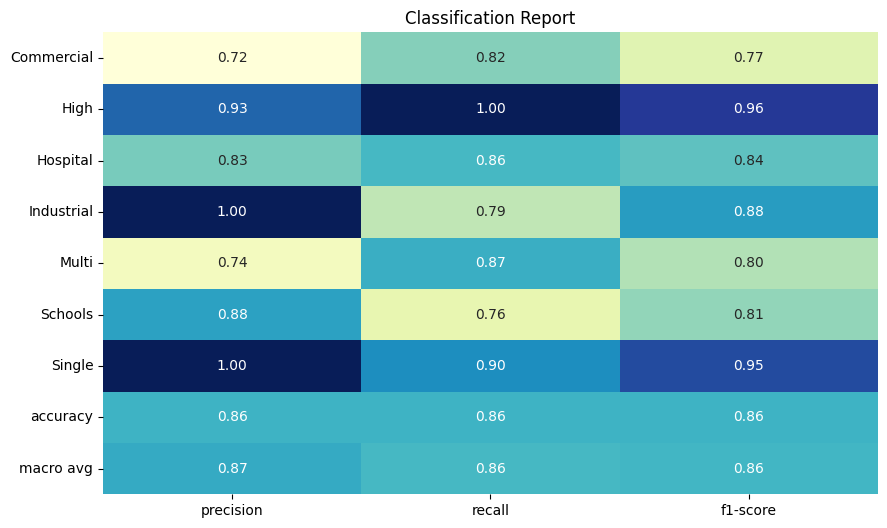


Final Test Accuracy: 86.1905%


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split  # Added for data splitting
from PIL import Image
import matplotlib.pyplot as plt  # Import for plotting training history
import logging  # Added for logging
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Enable mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

# Configure logging
logging.basicConfig(
    filename='model_training.log',
    level=logging.INFO,
    format='%(asctime)s:%(levelname)s:%(message)s'
)

# Verify GPU availability
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPUs Available:", gpus)
    logging.info(f"GPUs Available: {gpus}")
else:
    print("No GPU found. Please ensure that TensorFlow is configured properly.")
    logging.warning("No GPU found. Using CPU for training.")

# Set the image size and batch size
img_size = (224, 224)
batch_size = 32

# Set the base directories for the data
existing_train_dir = '/content/drive/MyDrive/RA Satellite Imagery Work/Abduls RA Work Folder/SAT_Images/Phase 2'
new_data_dir = '/content/drive/MyDrive/ML/Model/train'

# Function to get class names from training directories
def get_class_names(directories):
    class_names = set()
    for directory in directories:
        if not os.path.isdir(directory):
            logging.warning(f"Directory '{directory}' does not exist. Skipping.")
            continue
        classes_in_dir = [item for item in os.listdir(directory) if os.path.isdir(os.path.join(directory, item))]
        print(f"Classes in '{directory}': {classes_in_dir}")
        logging.info(f"Classes in '{directory}': {classes_in_dir}")
        class_names.update(classes_in_dir)
    class_names = sorted(list(class_names))
    print("Combined Classes from Training Directories:", class_names)
    logging.info(f"Combined Classes from Training Directories: {class_names}")
    return class_names

# Function to collect data paths from multiple directories
def collect_data_paths(data_directories, class_names):
    image_paths = []
    labels = []
    class_indices = {class_name: idx for idx, class_name in enumerate(class_names)}
    for data_directory in data_directories:
        if not os.path.isdir(data_directory):
            logging.warning(f"Data directory '{data_directory}' does not exist. Skipping.")
            continue
        for class_name in class_names:
            folder_path = os.path.join(data_directory, class_name)
            if not os.path.isdir(folder_path):
                logging.warning(f"Class directory '{folder_path}' does not exist. Skipping.")
                continue
            for img_file in os.listdir(folder_path):
                img_path = os.path.join(folder_path, img_file)
                if img_file.lower().endswith(('.tif', '.tiff', '.jpg', '.jpeg', '.png', '.bmp', '.gif')):
                    image_paths.append(img_path)
                    labels.append(class_indices[class_name])
    return image_paths, labels

# Function to load and preprocess image with PIL
def load_image_with_pil(filename):
    filename = filename.decode('utf-8')
    try:
        image = Image.open(filename).convert('RGB')
        image = image.resize(img_size)
        image = np.array(image) / 255.0  # Normalize to [0,1]
        return image.astype(np.float32)
    except Exception as e:
        logging.error(f"Error loading image {filename}: {e}")
        return np.zeros((*img_size, 3), dtype=np.float32)  # Return a black image in case of error

# Function to parse and preprocess images using PIL
def parse_function(filename, label):
    image = tf.numpy_function(load_image_with_pil, [filename], tf.float32)
    image.set_shape([img_size[0], img_size[1], 3])
    return image, label

# Data augmentation using Keras preprocessing layers
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

# Function to create datasets
def create_dataset(image_paths, labels, training=True):
    labels = np.array(labels)
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(parse_function, num_parallel_calls=tf.data.AUTOTUNE)
    if training:
        dataset = dataset.shuffle(buffer_size=1024)
        dataset = dataset.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# Function to build the model with regularization and adjusted dropout
def build_model(num_classes):
    with tf.device('/GPU:0'):
        base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))
        for layer in base_model.layers[:500]:
            layer.trainable = False
        for layer in base_model.layers[500:]:
            layer.trainable = True

        # Input layer
        inputs = Input(shape=(img_size[0], img_size[1], 3))
        x = inputs
        x = base_model(x, training=True)
        x = GlobalAveragePooling2D()(x)
        x = Dense(768, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)  # Added L2 regularization
        x = Dropout(0.5)(x)  # Increased dropout rate to 0.5
        outputs = Dense(num_classes, activation='softmax', dtype='float32')(x)

        model = Model(inputs, outputs)

        # Compile the model
        optimizer = Adam(learning_rate=5e-5)  # Adjusted learning rate
        optimizer = mixed_precision.LossScaleOptimizer(optimizer)
        model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

# Function to plot training history
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

# Function to train and evaluate the model
def train_and_evaluate(train_dirs, img_size=(224, 224), batch_size=32, epochs=20):
    class_names = get_class_names(train_dirs)

    # Collect all image paths and labels from training directories
    all_image_paths, all_labels = collect_data_paths(train_dirs, class_names)

    num_classes = len(class_names)
    print(f"Training with classes: {class_names}")
    logging.info(f"Training with classes: {class_names}")

    print(f"Total images collected: {len(all_image_paths)}")
    logging.info(f"Total images collected: {len(all_image_paths)}")

    # Split the data into train (80%), temp (20%)
    train_paths, temp_paths, train_labels, temp_labels = train_test_split(
        all_image_paths, all_labels, test_size=0.2, stratify=all_labels, random_state=42
    )
    print(f"Training images: {len(train_paths)}")
    print(f"Temp images (for validation and testing): {len(temp_paths)}")
    logging.info(f"Training images: {len(train_paths)}")
    logging.info(f"Temp images (for validation and testing): {len(temp_paths)}")

    # Further split temp into validation (10%) and test (10%)
    val_paths, test_paths, val_labels, test_labels = train_test_split(
        temp_paths, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42
    )
    print(f"Validation images: {len(val_paths)}")
    print(f"Test images: {len(test_paths)}")
    logging.info(f"Validation images: {len(val_paths)}")
    logging.info(f"Test images: {len(test_paths)}")

    # Create datasets
    train_dataset = create_dataset(train_paths, train_labels, training=True)
    val_dataset = create_dataset(val_paths, val_labels, training=False)
    test_dataset = create_dataset(test_paths, test_labels, training=False)

    # Build the model
    model = build_model(num_classes)
    logging.info("Model built and compiled successfully.")

    # Early stopping and learning rate scheduler
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)  # Reduced patience to 3
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)  # Learning rate scheduler

    # Train the model
    history = model.fit(
        train_dataset,
        epochs=epochs,
        validation_data=val_dataset,
        callbacks=[early_stopping, reduce_lr]
    )
    logging.info("Model training completed.")

    # Save the model
    model_save_path = '/content/drive/MyDrive/Madhu RA Work Folder/Densenet201_combined_3.h5'
    model.save(model_save_path)
    print(f"Model saved at {model_save_path}.")
    logging.info(f"Model saved at {model_save_path}.")

    # Plot training history
    plot_training_history(history)
    logging.info("Training history plotted.")

    # Evaluate on test dataset
    test_loss, test_accuracy = model.evaluate(test_dataset)
    print(f"Test Accuracy: {test_accuracy:.4%}")
    logging.info(f"Test Accuracy: {test_accuracy:.4%}")

    # Generate predictions and evaluate
    y_true = np.concatenate([y.numpy() for x, y in test_dataset], axis=0)
    y_pred_probs = model.predict(test_dataset)
    y_pred = np.argmax(y_pred_probs, axis=1)



    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot confusion matrix as heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()


    # Generate classification report as a dictionary
    cr_dict = classification_report(y_true, y_pred, labels=range(num_classes), target_names=class_names, zero_division=0, output_dict=True)

    # Convert to DataFrame
    cr_df = pd.DataFrame(cr_dict).transpose()

    # Plot the classification report as a heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(cr_df.iloc[:-1, :-1], annot=True, cmap="YlGnBu", fmt=".2f", cbar=False)
    plt.title("Classification Report")
    plt.show()

    return test_accuracy

if __name__ == "__main__":
    train_dirs = [existing_train_dir, new_data_dir]

    print("\nTraining model with combined training data:")
    logging.info("Starting model training with combined training data.")
    test_accuracy = train_and_evaluate(train_dirs, img_size=img_size, batch_size=batch_size, epochs=20)

    print(f"\nFinal Test Accuracy: {test_accuracy:.4%}")
    logging.info(f"Final Test Accuracy: {test_accuracy:.4%}")


In [ ]:
import numpy as np

# Define your confusion matrix
cm = np.array([
    [23, 0, 0, 0, 5, 0, 0],
    [0, 37, 0, 0, 0, 0, 0],
    [0, 1, 24, 0, 1, 2, 0],
    [4, 0, 0, 23, 1, 1, 0],
    [2, 2, 0, 0, 26, 0, 0],
    [1, 0, 0, 5, 1, 22, 0],
    [2, 0, 0, 0, 1, 0, 26]
])

# Calculate class-wise accuracy in percentage
class_accuracies = []
for i in range(len(cm)):
    class_accuracy = (cm[i][i] / sum(cm[i])) * 100
    class_accuracies.append(class_accuracy)

# Print the results
class_names = ["Commercial", "High", "Hospital", "Industrial", "Multi", "Schools", "Single"]
for i, class_name in enumerate(class_names):
    print(f"Accuracy for {class_name}: {class_accuracies[i]:.2f}%")


Accuracy for Commercial: 82.14%
Accuracy for High: 100.00%
Accuracy for Hospital: 85.71%
Accuracy for Industrial: 79.31%
Accuracy for Multi: 86.67%
Accuracy for Schools: 75.86%
Accuracy for Single: 89.66%


GPUs Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Training model with combined training data:
Classes in '/content/drive/MyDrive/ML/Model/train': ['Commercial', 'Hospital', 'High', 'Industrial', 'Schools', 'Single', 'Multi']
Classes in '/content/drive/MyDrive/Madhu RA Work Folder/misclassified_buildings': ['High', 'Commercial', 'Multi', 'Single', 'Hospital', 'Schools', 'Industrial']
Combined Classes from Training Directories: ['Commercial', 'High', 'Hospital', 'Industrial', 'Multi', 'Schools', 'Single']
Training with classes: ['Commercial', 'High', 'Hospital', 'Industrial', 'Multi', 'Schools', 'Single']
Training images: 2040
Validation images: 60
Test images: 60
Epoch 1/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 244s 2s/step - accuracy: 0.1510 - loss: 5.1818 - val_accuracy: 0.1000 - val_loss: 4.6320 - learning_rate: 1.0000e-05
Epoch 2/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 69s 700ms/step - accuracy: 0.1796 - loss: 4.9011 - val_accuracy: 0.0833 - val_loss: 4.9160 - learning_

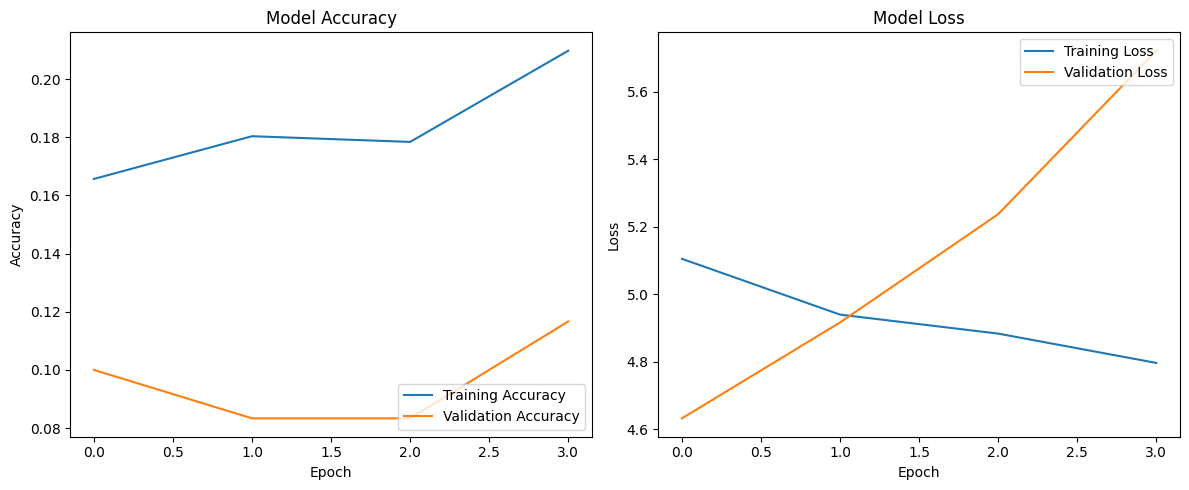

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 397ms/step - accuracy: 0.1833 - loss: 4.4421
Test Accuracy: 15.0000%
2/2 ━━━━━━━━━━━━━━━━━━━━ 37s 17s/step
Confusion Matrix:
 [[0 0 8 1 0 1 0]
 [0 1 5 3 0 0 1]
 [1 0 7 1 0 1 0]
 [0 1 6 1 0 0 2]
 [0 1 7 2 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 8 1 0 0 0]]
Classification Report:
               precision    recall  f1-score   support

  Commercial       0.00      0.00      0.00        10
        High       0.33      0.10      0.15        10
    Hospital       0.17      0.70      0.27        10
  Industrial       0.11      0.10      0.11        10
       Multi       0.00      0.00      0.00        10
     Schools       0.00      0.00      0.00         0
      Single       0.00      0.00      0.00        10

    accuracy                           0.15        60
   macro avg       0.09      0.13      0.08        60
weighted avg       0.10      0.15      0.09        60


Test Accuracy: 15.0000%


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report
from PIL import Image
import matplotlib.pyplot as plt  # Import for plotting training history

# Enable mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

# Verify GPU availability
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPUs Available:", gpus)
else:
    print("No GPU found. Please ensure that TensorFlow is configured properly.")

# Set the image size and batch size
img_size = (224, 224)
batch_size = 32

# Set the base directories for the data
existing_train_dir = '/content/drive/MyDrive/ML/Model/train'
new_data_dir = '/content/drive/MyDrive/Madhu RA Work Folder/misclassified_buildings'
existing_val_dir = '/content/drive/MyDrive/ML/Model/val'
existing_test_dir = '/content/drive/MyDrive/ML/Model/test'

# Function to get class names from training directories
def get_class_names(directories):
    class_names = set()
    for directory in directories:
        classes_in_dir = [item for item in os.listdir(directory) if os.path.isdir(os.path.join(directory, item))]
        print(f"Classes in '{directory}': {classes_in_dir}")
        class_names.update(classes_in_dir)
    class_names = sorted(list(class_names))
    print("Combined Classes from Training Directories:", class_names)
    return class_names

# Function to collect data paths from multiple directories
def collect_data_paths(data_directories, class_names):
    image_paths = []
    labels = []
    class_indices = {class_name: idx for idx, class_name in enumerate(class_names)}
    for data_directory in data_directories:
        for class_name in class_names:
            folder_path = os.path.join(data_directory, class_name)
            if os.path.isdir(folder_path):
                for img_file in os.listdir(folder_path):
                    img_path = os.path.join(folder_path, img_file)
                    if img_file.lower().endswith(('.tif', '.tiff', '.jpg', '.jpeg', '.png', '.bmp', '.gif')):
                        image_paths.append(img_path)
                        labels.append(class_indices[class_name])
    return image_paths, labels

# Function to load and preprocess image with PIL
def load_image_with_pil(filename):
    filename = filename.decode('utf-8')
    image = Image.open(filename).convert('RGB')
    image = image.resize(img_size)
    image = np.array(image) / 255.0  # Normalize to [0,1]
    return image.astype(np.float32)

# Function to parse and preprocess images using PIL
def parse_function(filename, label):
    image = tf.numpy_function(load_image_with_pil, [filename], tf.float32)
    image.set_shape([img_size[0], img_size[1], 3])
    return image, label

# More aggressive data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomBrightness(factor=0.1),
    tf.keras.layers.RandomContrast(factor=0.1),
])

# Function to create datasets
def create_dataset(image_paths, labels, training=True):
    labels = np.array(labels)
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(parse_function, num_parallel_calls=tf.data.AUTOTUNE)
    if training:
        dataset = dataset.shuffle(buffer_size=1024)
        dataset = dataset.batch(batch_size)
        dataset = dataset.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)
    else:
        dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# Function to build the model with increased regularization, batch normalization, and adjusted dropout
def build_model(num_classes):
    with tf.device('/GPU:0'):
        base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))
        for layer in base_model.layers[:500]:
            layer.trainable = False
        for layer in base_model.layers[500:]:
            layer.trainable = True

        # Input layer
        inputs = Input(shape=(img_size[0], img_size[1], 3))
        x = inputs
        x = base_model(x, training=True)
        x = GlobalAveragePooling2D()(x)
        x = Dense(768, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.002))(x)  # Increased L2 regularization
        x = BatchNormalization()(x)  # Added batch normalization
        x = Dropout(0.6)(x)  # Increased dropout rate to 0.6
        outputs = Dense(num_classes, activation='softmax', dtype='float32')(x)

        model = Model(inputs, outputs)

        # Compile the model
        optimizer = Adam(learning_rate=1e-5)  # Reduced learning rate
        optimizer = mixed_precision.LossScaleOptimizer(optimizer)
        model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

# Function to plot training history
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

# Function to train and evaluate the model
def train_and_evaluate(train_dirs, val_dir, test_dir, img_size=(224, 224), batch_size=32, epochs=20):
    class_names = get_class_names(train_dirs)

    train_image_paths, train_labels = collect_data_paths(train_dirs, class_names)
    val_image_paths, val_labels = collect_data_paths([val_dir], class_names)
    test_image_paths, test_labels = collect_data_paths([test_dir], class_names)

    num_classes = len(class_names)
    print(f"Training with classes: {class_names}")

    print(f"Training images: {len(train_image_paths)}")
    print(f"Validation images: {len(val_image_paths)}")
    print(f"Test images: {len(test_image_paths)}")

    train_dataset = create_dataset(train_image_paths, train_labels, training=True)
    val_dataset = create_dataset(val_image_paths, val_labels, training=False)
    test_dataset = create_dataset(test_image_paths, test_labels, training=False)

    model = build_model(num_classes)

    # Early stopping and learning rate scheduler
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)  # Reduced patience to 3
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)  # Learning rate scheduler

    history = model.fit(
        train_dataset,
        epochs=epochs,
        validation_data=val_dataset,
        callbacks=[early_stopping, reduce_lr]
    )

    model.save('/content/drive/MyDrive/Madhu RA Work Folder/Densenet201_combined.h5')

    plot_training_history(history)

    test_loss, test_accuracy = model.evaluate(test_dataset)
    print(f"Test Accuracy: {test_accuracy:.4%}")

    y_true = np.concatenate([y.numpy() for x, y in test_dataset], axis=0)
    y_pred_probs = model.predict(test_dataset)
    y_pred = np.argmax(y_pred_probs, axis=1)

    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:\n", cm)

    labels = range(num_classes)
    cr = classification_report(y_true, y_pred, labels=labels, target_names=class_names, zero_division=0)
    print("Classification Report:\n", cr)

    return test_accuracy

if __name__ == "__main__":
    train_dirs = [existing_train_dir, new_data_dir]

    print("\nTraining model with combined training data:")
    test_accuracy = train_and_evaluate(train_dirs, existing_val_dir, existing_test_dir)

    print(f"\nTest Accuracy: {test_accuracy:.4%}")


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import random
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array

# Additional imports for result visualization
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Building detection imports
from building_footprint_segmentation.seg.binary.models import ReFineNet
from building_footprint_segmentation.helpers.normalizer import min_max_image_net
from building_footprint_segmentation.utils.py_network import (
    to_input_image_tensor, add_extra_dimension, adjust_model
)

# Constants for building detection
MAX_SIZE = 512  # Model input size
MODEL_URL = "https://github.com/fuzailpalnak/building-footprint-segmentation/releases/download/alpha/refine.zip"
THRESHOLD = 0.4  # Adjusted threshold
MIN_BUILDING_SIZE = 500    # Minimum area of building to keep
MAX_BUILDING_SIZE = 100000  # Increased to allow larger connected regions

# Function to load building detection model
def get_trained_model():
    model = ReFineNet()
    set_model_weights(model)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()  # Set model to evaluation mode
    return model, device

# Load model weights
def set_model_weights(model):
    cache_dir = "./model_weights"
    os.makedirs(cache_dir, exist_ok=True)
    weights_path = os.path.join(cache_dir, "refine.pth")
    if not os.path.exists(weights_path):
        state_dict = torch.hub.load_state_dict_from_url(MODEL_URL, progress=True, map_location="cpu")
        torch.save(state_dict, weights_path)
    else:
        state_dict = torch.load(weights_path, map_location="cpu")
    if "model" in state_dict:
        state_dict = state_dict["model"]
    model.load_state_dict(adjust_model(state_dict))

# Resize image to MAX_SIZE while maintaining aspect ratio
def resize_image(image):
    original_height, original_width = image.shape[:2]
    if (original_height != MAX_SIZE) or (original_width != MAX_SIZE):
        resized_image = cv2.resize(image, (MAX_SIZE, MAX_SIZE), interpolation=cv2.INTER_AREA)
        return resized_image
    return image

# Implement Test-Time Augmentation (TTA)
def predict_with_tta(model, device, image_tensor):
    # Original prediction
    prediction = model(image_tensor).sigmoid()
    predictions = [prediction]

    # Augmentations: horizontal flip, vertical flip
    flips = [torch.flip(image_tensor, dims=[3]), torch.flip(image_tensor, dims=[2])]

    for flip in flips:
        pred_flip = model(flip).sigmoid()
        # Flip back
        if flip is flips[0]:
            pred_flip = torch.flip(pred_flip, dims=[3])
        else:
            pred_flip = torch.flip(pred_flip, dims=[2])
        predictions.append(pred_flip)

    # Average the predictions
    prediction_avg = torch.mean(torch.stack(predictions), dim=0)
    return prediction_avg

# Extract building mask and generate binary output
def extract(model, device, original_image):
    # Resize and normalize image
    resized_image = resize_image(original_image)
    normalized_image = min_max_image_net(img=resized_image)
    tensor_image = add_extra_dimension(to_input_image_tensor(normalized_image)).to(device)

    with torch.no_grad():
        # Predict building segmentation with TTA
        prediction = predict_with_tta(model, device, tensor_image)

    # Convert prediction to binary mask with adjusted threshold
    prediction_numpy = prediction.cpu().numpy()[0, 0]
    pred_binary = (prediction_numpy > THRESHOLD).astype(np.uint8)

    # Removed visualization of raw segmentation output and binary mask

    # Post-process the binary mask to remove noise and separate attached buildings
    cleaned_mask = postprocess_mask(pred_binary)

    # Removed visualization of cleaned mask after post-processing

    return cleaned_mask, resized_image

# Post-process the mask to remove small regions, noise, and separate attached buildings
def postprocess_mask(mask):
    # Apply morphological opening to remove small connections
    kernel_open = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel_open, iterations=2)

    # Separate attached buildings using watershed algorithm
    separated_mask = separate_attached_buildings(mask)

    # Remove small and large connected components
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(separated_mask, connectivity=8)
    sizes = stats[1:, cv2.CC_STAT_AREA]
    final_mask = np.zeros((labels.shape), np.uint8)

    for i in range(0, num_labels - 1):
        area = sizes[i]
        if MIN_BUILDING_SIZE <= area <= MAX_BUILDING_SIZE:
            final_mask[labels == i + 1] = 1

    return final_mask

# Function to separate attached buildings using watershed algorithm
def separate_attached_buildings(mask):
    # Compute the distance transform
    distance = cv2.distanceTransform(mask, cv2.DIST_L2, 5)
    # Normalize the distance image for display
    cv2.normalize(distance, distance, 0, 1.0, cv2.NORM_MINMAX)
    # Adjusted threshold to capture more peaks
    ret, sure_fg = cv2.threshold(distance, 0.1, 1.0, cv2.THRESH_BINARY)
    # Increase dilation iterations to better separate buildings
    kernel = np.ones((3, 3), np.uint8)
    sure_fg = cv2.dilate(sure_fg, kernel, iterations=2)
    # Finding unknown region
    sure_bg = cv2.dilate(mask, kernel, iterations=3)
    unknown = cv2.subtract(sure_bg, np.uint8(sure_fg))
    # Marker labeling
    ret, markers = cv2.connectedComponents(np.uint8(sure_fg))
    # Add one to all labels so that sure background is not 0, but 1
    markers = markers + 1
    # Mark the unknown regions with zero
    markers[unknown == 1] = 0
    # Apply watershed
    markers = cv2.watershed(cv2.cvtColor(mask * 255, cv2.COLOR_GRAY2BGR), markers)
    # Generate new mask with separated buildings
    separated_mask = np.zeros_like(mask)
    separated_mask[markers > 1] = 1

    # Removed visualization of markers for watershed

    return separated_mask

# Function to classify multiple building regions in a batch with extended bounding boxes
def classify_building_regions(image, contours, model, class_labels, padding=10):
    image_height, image_width = image.shape[:2]
    building_regions = []
    bboxes = []

    for contour in contours:
        # Extract the bounding box for the contour
        x, y, w, h = cv2.boundingRect(contour)

        # Extend the bounding box with padding
        x_new = max(0, x - padding)
        y_new = max(0, y - padding)
        x_max = min(image_width, x + w + padding)
        y_max = min(image_height, y + h + padding)
        w_new = x_max - x_new
        h_new = y_max - y_new

        # Extract the extended building region
        building_region = image[y_new:y_new + h_new, x_new:x_new + w_new]

        # Resize to match the input size of the classifier
        resized_region = cv2.resize(building_region, (224, 224))
        building_regions.append(resized_region)
        bboxes.append((x_new, y_new, w_new, h_new))

    if not building_regions:
        return []

    # Convert to array suitable for the classifier
    region_array = np.array([img_to_array(region) for region in building_regions])
    region_array = preprocess_input(region_array)

    # Predict using the classification model
    predictions = model.predict(region_array)
    top_class_indices = np.argmax(predictions, axis=1)
    probabilities = np.max(predictions, axis=1)
    top_classes = [class_labels[idx] for idx in top_class_indices]

    results = list(zip(top_classes, probabilities, bboxes))
    return results

# Process each image: segment it, classify detected buildings, and store results
def process_single_image(image_path, actual_class, model, device, classification_model, class_labels, visualize=False):
    try:
        # Load the original image
        original_image = cv2.imread(image_path)
        if original_image is None:
            raise ValueError(f"Error reading image {image_path}")

        # Convert to RGB
        original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

        # Run the building segmentation model
        pred_binary, resized_image = extract(model, device, original_image)

        # Find building contours
        contours, _ = cv2.findContours(pred_binary.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        building_contours = []
        for contour in contours:
            area = cv2.contourArea(contour)
            if MIN_BUILDING_SIZE <= area <= MAX_BUILDING_SIZE:
                building_contours.append(contour)

        # Show the number of buildings detected
        num_buildings = len(building_contours)
        print(f"{os.path.basename(image_path)}: Detected {num_buildings} building(s)")

        correct_predictions = 0
        total_predictions = 0
        vis_image = resized_image.copy()
        per_building_results = []  # List to store per-building results

        if num_buildings > 0:
            # Classify building regions in batch with extended bounding boxes
            classification_results = classify_building_regions(
                resized_image, building_contours, classification_model, class_labels, padding=20)

            # Draw bounding boxes and labels
            for i, (top_class, probability, bbox) in enumerate(classification_results):
                x, y, w, h = bbox

                # Draw bounding box (thin red box)
                cv2.rectangle(vis_image, (x, y), (x + w, y + h), (0, 255, 0), 2)

                # Prepare label text
                label = f"Predicted: {top_class} ({probability:.2f})\nActual: {actual_class}"
                y_offset = y - 10 if y - 10 > 10 else y + h + 20

                # Split label into lines
                label_lines = label.split('\n')
                font_scale = 0.5
                font = cv2.FONT_HERSHEY_SIMPLEX
                font_thickness = 1

                # Calculate text size for background rectangle
                text_sizes = [cv2.getTextSize(line, font, font_scale, font_thickness)[0] for line in label_lines]
                text_width = max([w for (w, h) in text_sizes])
                text_height = sum([h + 5 for (w, h) in text_sizes])

                # Set background rectangle coordinates
                rect_x1 = x
                rect_y1 = y_offset - text_height if y_offset - text_height > 0 else y_offset
                rect_x2 = x + text_width + 10
                rect_y2 = y_offset + 5

                # Draw filled rectangle for text background
                cv2.rectangle(vis_image, (rect_x1, rect_y1), (rect_x2, rect_y2), (255, 255, 255), -1)

                # Put text on the image
                text_y = rect_y1 + text_sizes[0][1] + 5
                for idx, line in enumerate(label_lines):
                    cv2.putText(vis_image, line, (x + 5, text_y), font, font_scale, (0, 0, 0), font_thickness)
                    text_y += text_sizes[idx][1] + 5

                # Print the classification result
                print(f"Building {i + 1} in {os.path.basename(image_path)}: Predicted: {top_class} ({probability:.4f}), Actual: {actual_class}")

                # Update accuracy counts
                total_predictions += 1
                if top_class == actual_class:
                    correct_predictions += 1

                # Store per-building result
                result = {
                    'actual_class': actual_class,
                    'predicted_class': top_class,
                    'correct': top_class == actual_class
                }
                per_building_results.append(result)

            if visualize:
                plt.figure(figsize=(10, 10))
                plt.imshow(vis_image)
                plt.title(f"Detected Buildings and Classifications in {os.path.basename(image_path)}")
                plt.axis('off')
                plt.show()
        else:
            print(f"No buildings detected in {os.path.basename(image_path)}.")

            if visualize:
                plt.figure(figsize=(10, 10))
                plt.imshow(original_image)
                plt.title(f"No buildings detected in {os.path.basename(image_path)}")
                plt.axis('off')
                plt.show()

        return correct_predictions, total_predictions, per_building_results
    except Exception as e:
        print(f"Failed to process {os.path.basename(image_path)}: {e}")
        return 0, 0, []

# Main function to process all images in the class folders
def process_images_in_folders(data_folder, model, device, classification_model, class_labels, visualize=False):
    total_correct = 0
    total_predictions = 0

    # Initialize per-class accuracy counts
    correct_predictions_per_class = {class_name: 0 for class_name in class_labels}
    total_predictions_per_class = {class_name: 0 for class_name in class_labels}

    # Lists to collect actual and predicted labels for confusion matrix
    y_true = []
    y_pred = []

    # Get list of class folders
    class_folders = [os.path.join(data_folder, d) for d in os.listdir(data_folder)
                     if os.path.isdir(os.path.join(data_folder, d))]

    # Collect all image paths and their actual classes
    image_paths = []
    for class_folder in class_folders:
        class_name = os.path.basename(class_folder)
        images_in_class = [os.path.join(class_folder, f) for f in os.listdir(class_folder)
                           if f.lower().endswith(('.tif', '.jpg', '.png', '.jpeg'))]
        for img_path in images_in_class:
            image_paths.append((img_path, class_name))

    # Shuffle image paths
    random.shuffle(image_paths)

    # Process images sequentially
    for image_path, actual_class in tqdm(image_paths):
        try:
            correct, total, per_building_results = process_single_image(
                image_path, actual_class, model, device, classification_model, class_labels, visualize=True)
            total_correct += correct
            total_predictions += total

            # Update per-class accuracy counts and collect labels
            for result in per_building_results:
                actual = result['actual_class']
                predicted = result['predicted_class']
                correct_predictions_per_class[actual] += int(result['correct'])
                total_predictions_per_class[actual] += 1

                # Collect labels for confusion matrix
                y_true.append(actual)
                y_pred.append(predicted)
        except Exception as e:
            print(f"Failed to process {image_path}: {e}")

    # Calculate overall accuracy
    if total_predictions > 0:
        accuracy = (total_correct / total_predictions) * 100
    else:
        accuracy = 0.0

    print(f"\nTotal correct predictions: {total_correct}")
    print(f"Total predictions: {total_predictions}")
    print(f"Overall Accuracy: {accuracy:.2f}%")

    # Calculate and print per-class accuracy
    print("\nAccuracy per class:")
    for class_name in class_labels:
        correct = correct_predictions_per_class[class_name]
        total = total_predictions_per_class[class_name]
        if total > 0:
            class_accuracy = (correct / total) * 100
            print(f"{class_name}: {class_accuracy:.2f}% ({correct}/{total})")
        else:
            print(f"{class_name}: No predictions.")

    # Generate confusion matrix and classification report
    if y_true and y_pred:
        # Generate confusion matrix
        cm = confusion_matrix(y_true, y_pred, labels=class_labels)
        plt.figure(figsize=(10, 7))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=class_labels, yticklabels=class_labels)
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.show()

        # Print classification report
        print("\nClassification Report:")
        print(classification_report(y_true, y_pred, labels=class_labels))

        # Analyze misclassifications
        print("\nMisclassified Samples:")
        misclassified = [(true, pred) for true, pred in zip(y_true, y_pred) if true != pred]
        for actual, predicted in misclassified:
            print(f'Actual: {actual}, Predicted: {predicted}')
    else:
        print("No predictions to generate confusion matrix and classification report.")

if __name__ == "__main__":
    # Data directory containing class folders
    data_folder = r'/content/drive/MyDrive/Madhu RA Work Folder/test'  # Update the path to your data folder

    # Define class labels (ensure these are in the correct order corresponding to your model's output)
    class_labels = ['Commercial', 'High', 'Hospital', 'Industrial', 'Multi', 'Schools', 'Single']  # Replace with your actual class names

    # Load building detection model and device
    model, device = get_trained_model()

    # Load the pre-trained classification model
    classification_model_path = r"/content/drive/MyDrive/Madhu RA Work Folder/Densenet201_combined.h5"  # Update the path to your model

    # Load the classification model
    try:
        classification_model = load_model(classification_model_path)
        print("Classification model loaded successfully.")
    except Exception as e:
        print(f"Error loading classification model: {e}")
        exit(1)

    # Set to True to visualize all images
    visualize = True  # Visualization is enabled to inspect building detections

    # Process all images in the data folder
    process_images_in_folders(data_folder, model, device, classification_model, class_labels, visualize)


Output hidden; open in https://colab.research.google.com to view.